# Importing Libraries

In [22]:
# import libraries
import numpy as np
import pandas as pd
from IPython.display import display
from IPython.core.display import HTML
from surprise import Dataset, Reader, SVD, accuracy
from collections import defaultdict
from surprise.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load Datasets

In [7]:
df_books = pd.read_csv("cleaned_books.csv")
df_ratings = pd.read_csv("cleaned_ratings.csv")

# Helper Function

In [8]:
# Function to display images in a DataFrame
def display_images(df, image_column):
    # Create an HTML representation of the DataFrame with images
    html = df.to_html(escape=False, formatters={
        image_column: lambda url: f'<img src="{url}" width="50">'
    })
    display(HTML(html))

# Collaborative Filtering Model-Based

## Prepare Data for Model

In [9]:
# Initializes a `Reader` object.
# Specifying that the ratings in the dataset are on a scale of 1 to 5.
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df_ratings[['user_id', 'book_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## Initialize and Train SVD Model

In [10]:
# Initializes and trains the Singular Value Decomposition (SVD) model.
model = SVD(n_factors=20)  
model.fit(trainset)

## Make Predictions on Test Set

In [11]:
# Uses the trained SVD `model` to make rating predictions for all user-item pairs 
# present in the `testset`.
predictions = model.test(testset)

## Function to Get Top-N Recommendations as DataFrame

In [12]:
def get_top_n_df(predictions, n=5, user_id=None):
    top_n = defaultdict(list)
    
    # Group predictions by user
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est, true_r))
    
    # Sort and retain top-n
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    
    # Filter if user_id is provided
    if user_id is not None:
        top_n = {user_id: top_n.get(user_id, [])}
    
    # Convert to DataFrame
    rows = []
    for uid, user_ratings in top_n.items():
        for iid, est_rating, true_rating in user_ratings:
            rows.append((iid, est_rating, true_rating))
    
    df_top_n = pd.DataFrame(rows, columns=['book_id', 'predicted_rating', 'actual_rating'])
    return df_top_n

## Display Top-N Recommendations for a Specific User

In [13]:
uid=2056
df_user = get_top_n_df(predictions, n=5, user_id=uid)
df_user = df_user.merge(df_books[['book_id', 'title', 'image_url']], on='book_id', how='left')

print("Top 5 recommended books for user", uid,":")
display_images(df_user, 'image_url')

Top 5 recommended books for user 2056 :


,book_id,predicted_rating,actual_rating,title,image_url
0,743,4.337454,3.0,"Lamb: The Gospel According to Biff, Christ's Childhood Pal",
1,1627,4.273012,4.0,"Twelve Sharp (Stephanie Plum, #12)",
2,318,4.259293,5.0,Orphan Train,
3,1606,4.232145,5.0,"Ten Big Ones (Stephanie Plum, #10)",
4,285,4.230808,4.0,"The Rosie Project (Don Tillman, #1)",


# Evaluation

## Function to Calculate Ranking Metrics @K

In [24]:
# Defines a function for evaluating recommendation quality.
# threshold: defaulting to 4.0, ratings >= 4.0 are considered relevant
def metrics_at_k(predictions, k, threshold=4.0):
    user_est_true = defaultdict(list)
    f1s = []
    recalls = []
    precisions = []
    reciprocal_ranks = []
    average_precisions = [] 
    
    for uid, iid, true_r, est, _ in predictions:
        user_est_true[uid].append((iid, est, true_r))
    
    # Sorts their items by predicted rating (estimated rating `est`).
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_k = user_ratings[:k]

        # Determines relevant items based on the true rating and the threshold.
        rel_items = [1 if true_r >= threshold else 0 for (_, _, true_r) in user_ratings]
        top_k_rel = [1 if true_r >= threshold else 0 for (_, _, true_r) in top_k]

        # Precision: Proportion of the top `k` recommended items that are relevant.
        # Recall: Proportion of all relevant items for the user that are in the top `k` recommendations.
        n_rel = sum(rel_items)
        n_rel_k = sum(top_k_rel)
        precision = n_rel_k / k if k else 0
        recall = n_rel_k / n_rel if n_rel else 0
        precisions.append(precision)
        recalls.append(recall)

        # F1@K: The harmonic mean of Precision@k and Recall@k.
        if precision + recall > 0:
            f1 = 2 * (precision * recall) / (precision + recall)
        else:
            f1 = 0
        f1s.append(f1)

        # MAP@K: Sum of precision values at each rank where a relevant item is found 
        # in the top k, divided by min(number of relevant items, k).
        num_hits, sum_prec = 0, 0.0
        for i, rel in enumerate(top_k_rel, 1):
            if rel:
                num_hits += 1
                sum_prec += num_hits / i
        average_precisions.append(sum_prec / min(n_rel, k) if n_rel else 0)

        # MRR@K: The reciprocal of the rank of the first relevant item in the top k.
        rr = 0
        for i, rel in enumerate(top_k_rel, 1):
            if rel:
                rr = 1 / i
                break
        reciprocal_ranks.append(rr)
        
    precision = np.mean(precisions)
    recall = np.mean(recalls)
    f1 = np.mean(f1s)
    map = np.mean(average_precisions)
    mrr = np.mean(reciprocal_ranks)

    return precision, recall, f1, map, mrr

## Function to Calculate Overall MAP and MRR

In [14]:
def get_user_ranks(preds, threshold=4.0):
    user_est_true = defaultdict(list)
    for uid, true_r, est, _ in preds:
        user_est_true[uid].append((est, true_r))
    
    APs = []
    RRs = []
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        num_relevant = 0
        precision_sum = 0
        rr = 0
        for i, (est, true_r) in enumerate(user_ratings):
            relevant = true_r >= threshold
            if relevant:
                num_relevant += 1
                precision_sum += num_relevant / (i + 1)
                if rr == 0:
                    rr = 1 / (i + 1)
        if num_relevant > 0:
            APs.append(precision_sum / num_relevant)
            RRs.append(rr)
    
    map_score = np.mean(APs)
    mrr_score = np.mean(RRs)
    return map_score, mrr_score

## Calculate and Print RMSE and MAE

In [15]:
rmse = accuracy.rmse(predictions, verbose=False)
mae = accuracy.mae(predictions, verbose=False)

print("RMSE:", rmse)
print("MAE:", mae)

RMSE: 0.8345627917464041
MAE: 0.6480127341922314


## Evaluate Model with Various Ranking Metrics @K


In [19]:
results = []

for k in range(1, 6):  
    precision, recall, f1, map_score, mrr = metrics_at_k(predictions, k=k)
    results.append({
        'num_recommendations': k,
        'precision@k': precision,
        'recall@k': recall,
        'f1-score@k': f1,
        'mAP@k': map_score,
        'MRR@k': mrr
    })

df_evaluation = pd.DataFrame(results)
df_evaluation

,num_recommendations,precision@k,recall@k,f1-score@k,mAP@k,MRR@k
0,1,0.873215,0.070891,0.127625,0.873215,0.873215
1,2,0.858913,0.137754,0.228502,0.837372,0.917635
2,3,0.846346,0.201904,0.311763,0.811948,0.924742
3,4,0.835018,0.263656,0.381737,0.792379,0.926572
4,5,0.824451,0.322907,0.441274,0.776639,0.927212


## Convert Precision and Recall to Percentage

In [20]:
df_evaluation['precision@k'] = df_evaluation['precision@k'] * 100
df_evaluation['recall@k'] = df_evaluation['recall@k'] * 100

## Plot Precision@k and Recall@k vs. Number of Recommendations

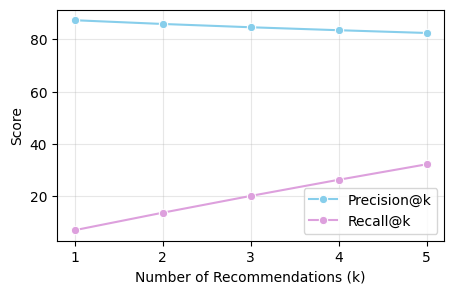

In [21]:
plt.figure(figsize=(5, 3))
sns.lineplot(
    data=df_evaluation,
    x='num_recommendations',
    y='precision@k',
    marker='o',
    label='Precision@k',
    color='skyblue'
)
sns.lineplot(
    data=df_evaluation,
    x='num_recommendations',
    y='recall@k',
    marker='o',
    label='Recall@k',
    color='plum'
)

plt.xlabel('Number of Recommendations (k)')
plt.ylabel('Score')
range_k = [1, 2, 3, 4, 5]
plt.xticks(np.arange(min(range_k), max(range_k)+1, 1.0))
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Tuning

In [ ]:
def model(latent_factors):
    model = SVD(n_factors=latent_factors)  
    model.fit(trainset)
    
    predictions = model.test(testset)
    
    return predictions

In [25]:
results = []

for l in tqdm(range(10, 101, 10), desc="Latent Factors", unit="factor"):  
    predictions = model(l)
    
    for k in tqdm(range(1, 6), desc="Recommendations", unit="rec"):
        precision, recall, f1, map_score, mrr = metrics_at_k(predictions, k=k)
        results.append({
            'Latent Factor': l,
            'Number of Recommendations': k,
            'precision@k': precision,
            'recall@k': recall,
        })

df_evaluation = pd.DataFrame(results)
df_evaluation

Latent Factors: 100%|██████████| 10/10 [26:51<00:00, 161.19s/factor]


,Latent Factor,Number of Recommendations,precision@k,recall@k
0,10,1,0.871361,0.070599
1,10,2,0.856498,0.137337
2,10,3,0.844006,0.201123
3,10,4,0.832571,0.262535
4,10,5,0.822381,0.321861
5,20,1,0.874562,0.071036
6,20,2,0.858380,0.137709
7,20,3,0.845117,0.201367
8,20,4,0.834017,0.262939
9,20,5,0.823815,0.322521


In [31]:
df_evaluation['precision@k'] = df_evaluation['precision@k'] * 100
df_evaluation['recall@k'] = df_evaluation['recall@k'] * 100

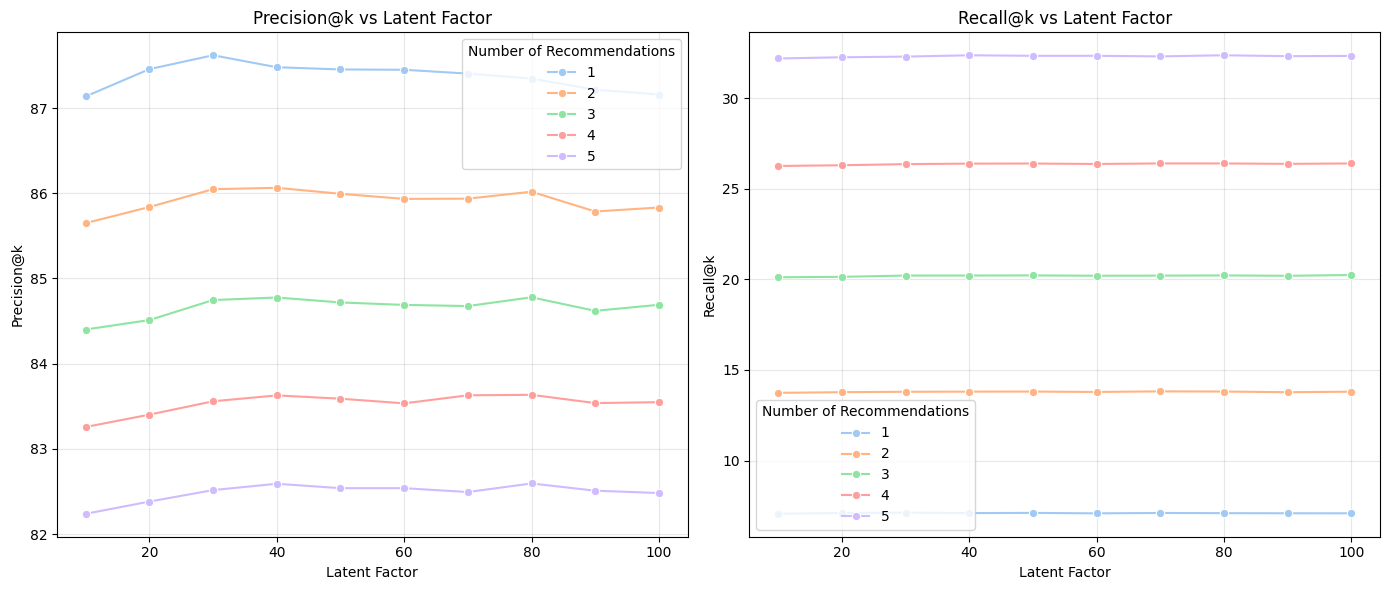

In [37]:
# Plotting precision@k and recall@k vs Latent Factor for different k values
plt.figure(figsize=(14, 6))

# Precision plot
plt.subplot(1, 2, 1)
sns.lineplot(data=df_evaluation, x="Latent Factor", y="precision@k", 
             hue="Number of Recommendations", palette="pastel", marker="o")
plt.title("Precision@k vs Latent Factor")
plt.ylabel("Precision@k")
plt.xlabel("Latent Factor")
plt.grid(alpha=0.3)

# Recall plot
plt.subplot(1, 2, 2)
sns.lineplot(data=df_evaluation, x="Latent Factor", y="recall@k", 
             hue="Number of Recommendations", palette="pastel", marker="o")
plt.title("Recall@k vs Latent Factor")
plt.ylabel("Recall@k")
plt.xlabel("Latent Factor")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()